In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import glob as gb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from zipfile import ZipFile
import cv2

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, LSTM, Dense, Concatenate, Attention, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load the dataset
df_path = '/content/dataset.csv'
df = pd.read_csv(df_path)


In [ ]:
# Display basic information about the dataset
print(df.info())

# Display descriptive statistics
#print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6424 entries, 0 to 6423
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      6424 non-null   int64  
 1   t/s     6424 non-null   float64
 2   p       6424 non-null   float64
 3   q       6424 non-null   float64
 4   r       6424 non-null   float64
 5   mx      6424 non-null   float64
 6   my      6424 non-null   float64
 7   mz      6424 non-null   float64
 8   m1      6424 non-null   float64
 9   m2      6424 non-null   float64
 10  m3      6424 non-null   float64
 11  m4      6424 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 602.4 KB
None


In [ ]:
# Step 4: Display the first few rows of the modified sheet

print(df.head())
print("\n")

   ID   t/s         p         q         r        mx        my            mz  \
0   1  2.11  0.000216  0.003440  0.000043  0.000136  0.000025  4.860000e-07   
1   2  2.12  0.000279  0.003451  0.000043  0.000131  0.000025  5.200000e-07   
2   3  2.13  0.000339  0.003463  0.000044  0.000126  0.000024  5.530000e-07   
3   4  2.14  0.000397  0.003474  0.000044  0.000121  0.000024  5.860000e-07   
4   5  2.15  0.000453  0.003484  0.000044  0.000116  0.000024  6.180000e-07   

    m1   m2   m3   m4  
0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  




In [ ]:
# Define features and labels
feature_columns = ['p', 'q', 'r', 'mx', 'my', 'mz']
label_columns = ['m1', 'm2', 'm3', 'm4']


In [ ]:
# Define a function to classify faults for all motors
def classify_fault(row):
    max_fault_value = max(row['m1'], row['m2'], row['m3'], row['m4'])
    if max_fault_value >= 0.4:
        return 'Fault 8'
    elif max_fault_value >= 0.35:
        return 'Fault 7'
    elif max_fault_value >= 0.30:
        return 'Fault 6'
    elif max_fault_value >= 0.25:
        return 'Fault 5'
    elif max_fault_value >= 0.20:
        return 'Fault 4'
    elif max_fault_value >= 0.15:
        return 'Fault 3'
    elif max_fault_value >= 0.10:
        return 'Fault 2'
    elif max_fault_value >= 0.05:
        return 'Fault 1'
    else:
        return 'No Fault'

# Apply the function to classify the faults
df['fault_classification'] = df.apply(classify_fault, axis=1)


In [ ]:
# Use LabelEncoder to encode the labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['fault_classification'])
num_classes = len(label_encoder.classes_)


In [ ]:
# Standardize your features
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df['label_encoded'], test_size=0.2, random_state=42)

In [ ]:
# Reshape your input data for the CNN and LSTM branches
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# One-Hot Encode your labels (if using categorical crossentropy loss)
from keras.utils import to_categorical

y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# Display shapes to ensure everything is correct
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_train_lstm shape:", X_train_lstm.shape)
print("y_train_onehot shape:", y_train_onehot.shape)


X_train_cnn shape: (5139, 6, 1)
X_train_lstm shape: (5139, 6, 1)
y_train_onehot shape: (5139, 9)


In [ ]:
# Define input shape for both CNN and LSTM
input_shape = (X_train_cnn.shape[1], 1)

# CNN branch
cnn_input = Input(shape=input_shape)

cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
cnn1 = GlobalAveragePooling1D()(cnn1)

cnn2 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
cnn2 = GlobalAveragePooling1D()(cnn2)

cnn3 = Conv1D(filters=48, kernel_size=5, activation='relu')(cnn_input)

cnn3 = GlobalAveragePooling1D()(cnn3)

cnn4 = Conv1D(filters=48, kernel_size=5, activation='relu')(cnn_input)

cnn4 = GlobalAveragePooling1D()(cnn4)

cnn5 = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)

cnn5 = GlobalAveragePooling1D()(cnn5)

cnn6 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
cnn6 = GlobalAveragePooling1D()(cnn6)

# Concatenate the outputs of CNN layers
merged_cnn = Concatenate()([cnn1, cnn2, cnn3, cnn4, cnn5, cnn6])

# Dense layers for CNN
dense_cnn = Dense(32, activation='relu')(merged_cnn)
dense_cnn = Dropout(0.05)(dense_cnn)  # Adding dropout layer
dense_cnn = Dense(32, activation='relu')(dense_cnn)

# LSTM branch
lstm_input = Input(shape=input_shape)
lstm = LSTM(units=32, return_sequences=True)(lstm_input)
lstm = Attention()([dense_cnn, lstm])
lstm = GlobalAveragePooling1D()(lstm)

# Concatenate the outputs of CNN and LSTM
merged = Concatenate()([dense_cnn, lstm])

# Dense layers for classification
dense = Dense(64, activation='relu')(merged)

# Corrected output layer
output = Dense(num_classes, activation='softmax')(dense)

# Create the model
model = Model(inputs=[cnn_input, lstm_input], outputs=output)


# Display the model summary
model.summary()



Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 6, 1)]               0         []                            
                                                                                                  
 conv1d_109 (Conv1D)         (None, 4, 32)                128       ['input_32[0][0]']            
                                                                                                  
 conv1d_110 (Conv1D)         (None, 4, 32)                128       ['input_32[0][0]']            
                                                                                                  
 conv1d_111 (Conv1D)         (None, 2, 48)                288       ['input_32[0][0]']            
                                                                                           

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a custom learning rate
custom_learning_rate = 0.004

# Create an instance of the Adam optimizer with the custom learning rate
custom_optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model with the custom optimizer and appropriate loss function
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best models based on validation accuracy
checkpoint = ModelCheckpoint(filepath='best_model_{epoch:02d}.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit([X_train_cnn, X_train_lstm], y_train, epochs=100, batch_size=32, validation_data=([X_test_cnn, X_test_lstm], y_test), callbacks=[checkpoint])


Epoch 1/100
161/161 [==============================] - ETA: 0s - loss: 0.7602 - accuracy: 0.7319
Epoch 1: val_accuracy improved from -inf to 0.79144, saving model to best_model_01.h5
161/161 [==============================] - 7s 14ms/step - loss: 0.7602 - accuracy: 0.7319 - val_loss: 0.4250 - val_accuracy: 0.7914
Epoch 2/100
 14/161 [=>............................] - ETA: 1s - loss: 0.4039 - accuracy: 0.8170

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/161 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.8467
Epoch 2: val_accuracy improved from 0.79144 to 0.84125, saving model to best_model_02.h5
161/161 [==============================] - 2s 10ms/step - loss: 0.3966 - accuracy: 0.8471 - val_loss: 0.3629 - val_accuracy: 0.8412
Epoch 3/100
159/161 [============================>.] - ETA: 0s - loss: 0.3846 - accuracy: 0.8473
Epoch 3: val_accuracy improved from 0.84125 to 0.87938, saving model to best_model_03.h5
161/161 [==============================] - 2s 12ms/step - loss: 0.3850 - accuracy: 0.8467 - val_loss: 0.3801 - val_accuracy: 0.8794
Epoch 4/100
157/161 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8929
Epoch 4: val_accuracy improved from 0.87938 to 0.88405, saving model to best_model_04.h5
161/161 [==============================] - 1s 9ms/step - loss: 0.3241 - accuracy: 0.8932 - val_loss: 0.3195 - val_accuracy: 0.8840
Epoch 5/100
160/161 [============================>.] - ETA:

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test_cnn, X_test_lstm], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

41/41 [==============================] - 0s 3ms/step - loss: 0.0954 - accuracy: 0.9681
Test Loss: 0.09544660896062851
Test Accuracy: 0.9680933952331543


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
best_model = load_model('/content/best_model_96.h5')  # Adjust the filename if necessary

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate([X_test_cnn, X_test_lstm], y_test)
print("Best Model Test Loss:", test_loss)
print("Best Model Test Accuracy:", test_accuracy)


41/41 [==============================] - 1s 6ms/step - loss: 0.0833 - accuracy: 0.9735
Best Model Test Loss: 0.08329707384109497
Best Model Test Accuracy: 0.9735408425331116


In [ ]:
# Predict on the test data
predictions = model.predict([X_test_cnn, X_test_lstm])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode labels using LabelEncoder
decoded_predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Compare predicted labels with actual labels
comparison_df = pd.DataFrame({'Actual': label_encoder.inverse_transform(y_test), 'Predicted': decoded_predicted_labels})
print(comparison_df)

41/41 [==============================] - 1s 3ms/step
        Actual Predicted
0     No Fault  No Fault
1     No Fault  No Fault
2      Fault 3   Fault 3
3     No Fault  No Fault
4     No Fault  No Fault
...        ...       ...
1280  No Fault  No Fault
1281  No Fault  No Fault
1282   Fault 3   Fault 3
1283  No Fault  No Fault
1284   Fault 1   Fault 1

[1285 rows x 2 columns]


In [ ]:
# Define a function to map fault classifications to corresponding motors
def map_fault_to_motor(fault):
    if fault == 'Fault 8':
        return 'm3'  # Assuming Fault 8 corresponds to motor m3
    elif fault in ['Fault 1', 'Fault 2', 'Fault 3', 'Fault 4', 'Fault 5', 'Fault 6', 'Fault 7']:
        return 'm1'  # Assuming Faults 1 to 7 correspond to motor m1
    else:
        return None  # Handle the case where fault is not recognized or not applicable to any motor

# Map predicted fault classifications to corresponding motors
df['Motor'] = df['fault_classification'].apply(map_fault_to_motor)

# Print the DataFrame with fault classifications and corresponding motors
print(df[['fault_classification', 'Motor']])


     fault_classification Motor
0                No Fault  None
1                No Fault  None
2                No Fault  None
3                No Fault  None
4                No Fault  None
...                   ...   ...
6419              Fault 8    m3
6420              Fault 8    m3
6421              Fault 8    m3
6422              Fault 8    m3
6423              Fault 8    m3

[6424 rows x 2 columns]


41/41 [==============================] - 0s 3ms/step


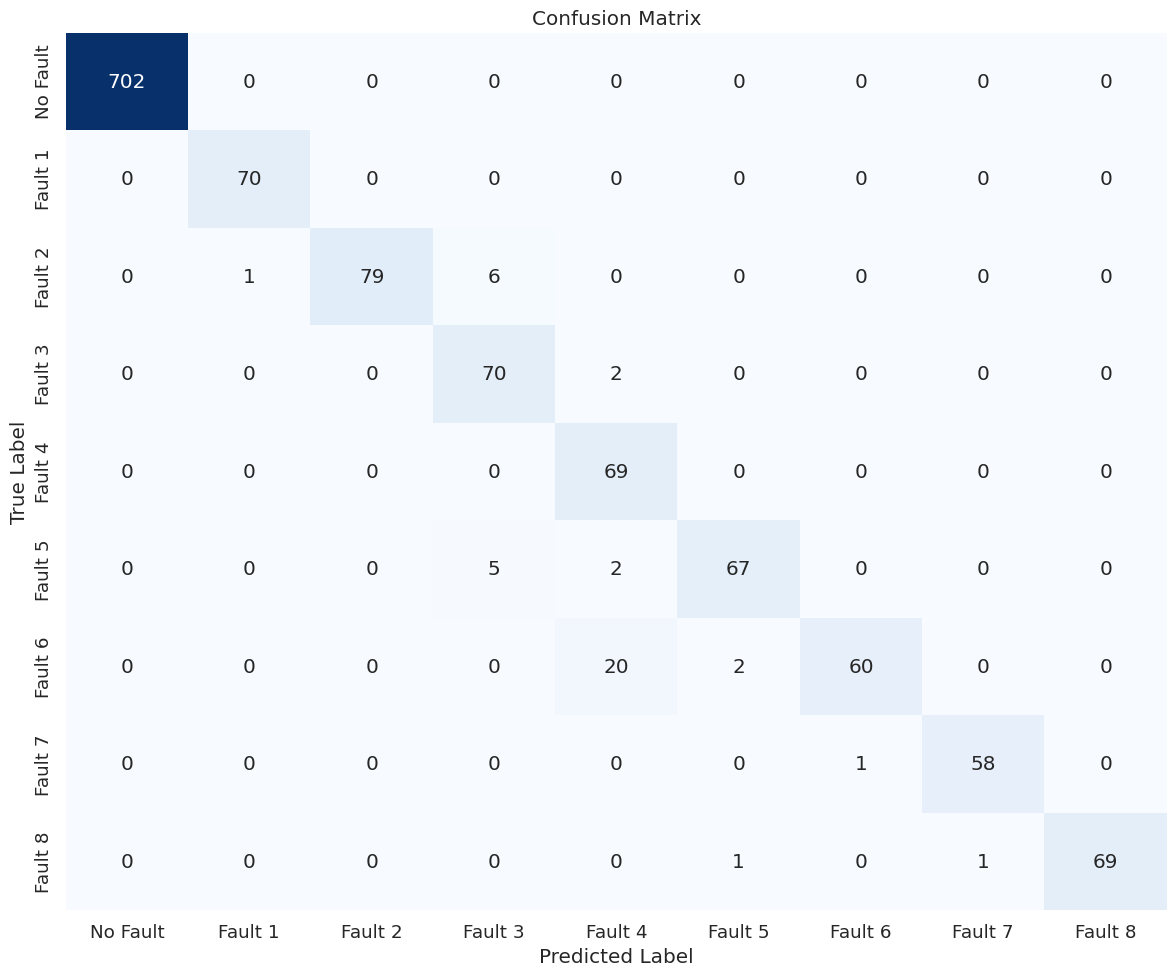

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test data
test_predictions = model.predict([X_test_cnn, X_test_lstm])
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert one-hot encoded true labels to categorical labels
decoded_actual_labels = label_encoder.inverse_transform(y_test)

# Convert predicted labels to categorical labels
decoded_predicted_labels = label_encoder.inverse_transform(test_predicted_labels)

# Define class names (fault types)
class_names = ['No Fault', 'Fault 1', 'Fault 2', 'Fault 3', 'Fault 4', 'Fault 5', 'Fault 6', 'Fault 7', 'Fault 8']

# Create confusion matrix
conf_matrix = confusion_matrix(decoded_actual_labels, decoded_predicted_labels, labels=class_names)

# Set seaborn style
sns.set(style='whitegrid', font_scale=1.2)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()

# Save the figure with dpi 400
plt.savefig('confusion_matrix.png', dpi=400)

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Get predictions on the test data
test_predictions = model.predict([X_test_cnn, X_test_lstm])
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Define class names (fault types)
class_names = ['No Fault', 'Fault 1', 'Fault 2', 'Fault 3', 'Fault 4', 'Fault 5', 'Fault 6', 'Fault 7', 'Fault 8']

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, test_predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


41/41 [==============================] - 0s 4ms/step
Confusion Matrix:
[[ 70   0   0   0   0   0   0   0   0]
 [  1  79   6   0   0   0   0   0   0]
 [  0   0  70   2   0   0   0   0   0]
 [  0   0   0  69   0   0   0   0   0]
 [  0   0   5   2  67   0   0   0   0]
 [  0   0   0  20   2  60   0   0   0]
 [  0   0   0   0   0   1  58   0   0]
 [  0   0   0   0   1   0   1  69   0]
 [  0   0   0   0   0   0   0   0 702]]


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = model.predict([X_test_cnn, X_test_lstm])

# Convert predictions to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Decode class labels using the inverse of LabelEncoder
decoded_predictions = label_encoder.inverse_transform(y_pred_classes)

# Convert one-hot encoded fault values to actual values
decoded_actual_values = label_encoder.inverse_transform(y_test)

# Generate classification report
report = classification_report(decoded_actual_values, decoded_predictions)
print("Classification Report:\n", report)


41/41 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

     Fault 1       0.99      1.00      0.99        70
     Fault 2       1.00      0.92      0.96        86
     Fault 3       0.86      0.97      0.92        72
     Fault 4       0.74      1.00      0.85        69
     Fault 5       0.96      0.91      0.93        74
     Fault 6       0.98      0.73      0.84        82
     Fault 7       0.98      0.98      0.98        59
     Fault 8       1.00      0.97      0.99        71
    No Fault       1.00      1.00      1.00       702

    accuracy                           0.97      1285
   macro avg       0.95      0.94      0.94      1285
weighted avg       0.97      0.97      0.97      1285



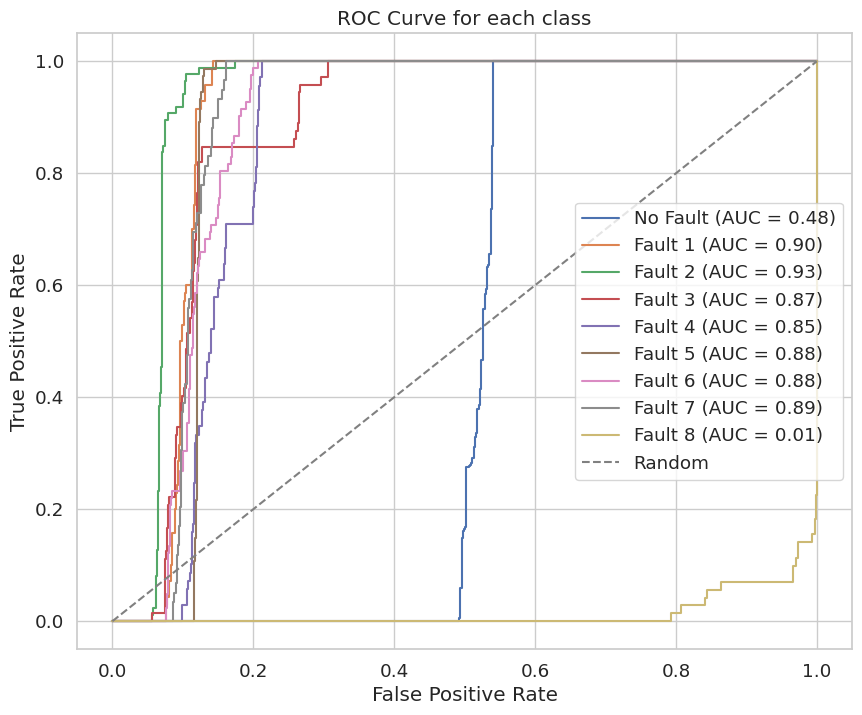

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Define class names
class_names = ['No Fault', 'Fault 1', 'Fault 2', 'Fault 3', 'Fault 4', 'Fault 5', 'Fault 6', 'Fault 7', 'Fault 8']

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((decoded_actual_values == class_names[i]).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, cohen_kappa_score


# Calculate F1-score, Matthews correlation coefficient (MCC), and Cohen's Kappa
f1 = f1_score(decoded_actual_values, decoded_predictions, average='weighted')
mcc = matthews_corrcoef(decoded_actual_values, decoded_predictions)
kappa = cohen_kappa_score(decoded_actual_values, decoded_predictions)

# Display the additional metrics
print(f"F1-Score: {f1:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")


F1-Score: 0.9682
Matthews Correlation Coefficient: 0.9533
Cohen's Kappa: 0.9528
